# Build Environment

In [ ]:
import numpy as np
from tqdm import tqdm

class Environment(object):
  
  # Declare environment variables
  def __init__(self, ):
    
    # Set the number of states, actions, and depth. The code is for balanced trees. The horizon is equal to L+1
    self.num_states =  15 # 31 # 15
    self.num_actions = 2
    self.L = 4 # 5 # 4
    self.horizon = self.L + 1

    self.episodes = 10000
    self.num_trials = 20
    self.discount_factor = 1.0

    self.start_state = 0

    self.S = np.array([i for i in range(self.num_states)])
    self.pi_e = np.zeros((self.num_states, self.num_actions))

    for s in range(self.num_states):
      # self.pi_e[s] = [0.95, 0.05] # Works well
      # self.pi_e[s] = [0.99, 0.01] # Maybe
      self.pi_e[s] = [0.9, 0.1] # Works best
        
    

    self.R = np.zeros((self.num_states, self.num_actions))

    for s in range(self.num_states):
      for a in range(self.num_actions):
        self.R[s][a] = 1
    
    

    self.var = np.zeros((self.num_states, self.num_actions))
    

    for s in range(self.num_states):
      self.var[s][0] = 0.01
      self.var[s][1] = 50 #10 works good

    max_var = 3*np.sqrt(np.max(self.var)) + np.max(self.R)
    min_var = -3*np.sqrt(np.min(self.var)) + np.min(self.R)
    # self.ucb_constant = (max_var - min_var)**2/2.0
    self.ucb_constant = 2
    # print(max_var, min_var, self.ucb_constant)

    # Calculate the set of all leaves

    leaf_starting_index = int(self.num_states - np.floor(self.num_states/2))
    self.leaf_set = [i for i in range(leaf_starting_index-1, self.num_states)]
    

    self.special_state = np.array([-1,-1])
    self.goal_state = np.copy(self.leaf_set)

    # self.ucb_constant = 1.0

    
    self.level = []
    self.calculate_level()
    self.reset()
  
  def calculate_level(self, ):

    self.level.append((0,0))
    curr_state = 1
    for ell in range(1,self.L+1):
      for i in range(curr_state, curr_state + (self.num_actions**ell)):
        self.level.append((i,ell))
      curr_state = curr_state+(self.num_actions**ell)
  
  def find_leaves(self, s):

    next_set = []
    next_action = []
    if s in self.leaf_set:
      next_set.append(s)
      return next_set, [i for i in range(self.num_actions)]
    for action in range(self.num_actions):
      next_set.append(2*s+(action+1)) # 2s + (a + 1)
      next_action.append(action)

    return next_set, next_action

  def get_level(self, s):
    for x in self.level:
      if x[0] == s:
        # print(x[1])
        return x[1]
  
  def reset(self, ):

    self.curr_state = 0
    self.next_state = 0
  
  
  def step(self, action):

    # noise = np.sqrt(self.var[0][action])*np.random.randn() # The sqrt has to be there
    
    #
    if self.curr_state not in self.leaf_set: # if you are in leaf state, the next state is self state
      if action == 0:
        self.next_state = 2*self.curr_state + 1 
        reward = self.R[self.curr_state][0]
      if action == 1:
        self.next_state = 2*self.curr_state + 2 
        reward = self.R[self.curr_state][1]
    else:
      if action == 0:
        self.next_state = self.curr_state 
        reward = self.R[self.curr_state][0]
      if action == 1:
        self.next_state = self.curr_state
        reward = self.R[self.curr_state][1]
    
    self.curr_state = self.next_state
    return self.next_state, reward + np.sqrt(self.var[self.curr_state][action])*np.random.randn() # The sqrt has to be there

env = Environment()  
# print(env.pi_e, env.R, env.var, env.leaf_set, env.level) 
print("leaf set:", env.leaf_set) 
print("env level:", env.level)
# for ep in range(5):
#   env.reset()
#   for t in range(env.horizon):
#     a = np.random.randint(2)
#     print(env.curr_state,a)
#     next_state, reward =env.step(a)
#     print(next_state, reward)


leaf set: [7, 8, 9, 10, 11, 12, 13, 14]
env level: [(0, 0), (1, 1), (2, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4)]


## Debug

In [ ]:
b = np.zeros((env.L, env.num_states, env.num_actions))
B = np.zeros((env.L, env.num_states))

for t in range(env.L-1, -1, -1):
  for s in env.leaf_set:
    sum_ = 0.0
    for a in range(env.num_actions):
      b[t][s][a] = np.sqrt(env.pi_e[s][a]**2 * env.var[s][a]**2)
      sum_ += b[t][s][a]
    B[t][s] = sum_ 
    

  for s in range(env.num_states-1,-1,-1):
    # print("s: ",s)
    if s not in env.leaf_set:
      for a in range(env.num_actions):
        B_ = 0.0
        child_set = [2*s + 1, 2*s + 2]
        # print(child_set)
        for s1 in child_set:
          B_ += B[t][s1]**2
        # print("B_: ", B_)
        b[t][s][a] = np.sqrt(env.pi_e[s][a]**2 * (env.var[s][a]**2 + env.discount_factor**2 * B_ ) )
      B[t][s] = np.sum(b[t][s])
      # print(b[t][s])

print(b[0])
print(B[0])


[[2.51970858e+01 5.73046122e+00]
 [1.45421035e+01 5.25459551e+00]
 [1.45421035e+01 5.25459551e+00]
 [6.37542251e+00 5.04993085e+00]
 [6.37542251e+00 5.04993085e+00]
 [6.37542251e+00 5.04993085e+00]
 [6.37542251e+00 5.04993085e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]
 [9.00000000e-03 5.00000000e+00]]
[30.92754704 19.79669901 19.79669901 11.42535337 11.42535337 11.42535337
 11.42535337  5.009       5.009       5.009       5.009       5.009
  5.009       5.009       5.009     ]


# Value Iteration

In [ ]:
class value_iteration(object):

  def __init__(self,):
    ''''
    Init
    '''
    self.env = Environment()

  def run_value_iteration(self, b):
    
    # self.V = np.random.uniform(0,1, size = (limit, self.env.num_states, self.env.num_states))
    self.V = np.zeros((self.env.horizon, self.env.num_states)) # Intialize to 0
    # self.V[0][self.env.goal_state[0]][self.env.goal_state[1]] = 0


    m = self.env.horizon - 1

    while True:
      for s in range(self.env.num_states-1, -1, -1): # Start from the end states
        val = []
        # print("s:", s)
        next_states, next_actions = env.find_leaves(s)
        # print(next_states, next_actions)
        for action in next_actions:
            
          val_next_states = 0.0 # Summing over the values of the next states
          for s1 in next_states:
              
            # Not using P as this is deterministic
            if m == self.env.horizon - 1:
              # val_next_states += self.V[m][s1]
              val_next_states = 0.0
            else:
              val_next_states += self.V[m+1][s1]
          # print(b[curr_state[0]][curr_state[1]][action]) 
          val_ = env.pi_e[s][action]*( b[s][action] + self.env.discount_factor*val_next_states )
          val.append(val_)
            
        self.V[m][s] = np.sum(val)
          
      # if m >= limit-1 and limit!= -1:
      # if m >= self.env.horizon-1:
      #   break
      if m <= 0:
        break
      m -= 1
      # print(V)
    return self.V
    
env = Environment()
# print(env.R)
vi_pi_e = value_iteration()
V = vi_pi_e.run_value_iteration(env.R)
print(V[0][0])

# x = env.R_ + np.random.uniform(0,0.001, size = (env.num_states, env.num_states, env.num_actions))
# V = vi_pi_e.run_value_iteration(env.P, x, limit =  100, state_transition = True)
# print(V[0][0][0])

print(V[0])

23.0
[23. 15. 15.  9.  9.  9.  9.  5.  5.  5.  5.  5.  5.  5.  5.]


# On Policy Sampling

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class OnPolicySampling(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = 1.0
    self.episodes = env.episodes
    self.env = env
    self.reset()
  
  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.value_iter = value_iteration()
    
  
  def onpolicy(self, s, action_list, pi_e):

    
    return np.random.choice(action_list, p = pi_e[s])
    

  def run_OnPolicySampling(self, env, tr):

    self.reset()
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes,self.num_states))

    action_list = [i for i in range(self.num_actions)]
    np.random.seed(tr)
    

    for eps in tqdm(range(0,self.episodes), total=self.episodes):
      env.reset()
      for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
      # for t in range(env.horizon):

        curr_state = env.curr_state
        action = self.onpolicy(curr_state, action_list, self.pi_e)
        next_state, reward = env.step(action)

        self.visit[curr_state][action] += 1
        self.sum_reward[curr_state][action] += reward
        self.q[curr_state][action] = self.sum_reward[curr_state][action]/self.visit[curr_state][action]
      
        
        # self.v[0] += reward*self.discount_factor
      
      # self.v_pi[eps] = np.dot(self.q[0], env.pi_e[0])
      # self.v_pi[eps] = np.sum(np.multiply(self.q,env.pi_e), axis = 1)
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.q)[0]

    # return self.v_pi
    file = open("/content/f_onpolicy_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()
  
  def run_OnPolicy(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_onpolicy = np.zeros((env.num_trials, env.episodes, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_OnPolicySampling, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_onpolicy_"+str(tr), 'rb')
      v_pi_onpolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_onpolicy

# Confidence Bound Method with Variance

Sample next action as $\max_{a\in[A]} CB_a$ where $CB_a = R\pi^2_e\left(\sqrt{\dfrac{2 \widehat{\sigma}_a^2 \log t}{n_a}} + \dfrac{7 \log t}{3 n_a}\right)$ where $R$ is the upper bound to the maximum possible reward.

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle


class CBVar_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.ucb = 100*np.ones(self.num_actions)
    self.episodes = env.episodes
    self.env = env
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.value_iter = value_iteration()

    self.ucb = np.zeros((self.num_states, self.num_actions))
    
  

  def cbvar_policy(self, s, action_list, t):
    
    
    # Explore each arm once in the state
    level = self.env.get_level(s)
    explore_arms = []
    for i in range(self.num_actions): 
      if self.visit[s][i] <= 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      # print(np.argmax(self.ucb))
      return np.argmax(self.ucb[s]) # return deterministically the best ucb

    else:
      return np.argmin(self.visit[s]) # return the arm sampled least in state s when unexplored set is non-empty
    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    traj = np.zeros((env.horizon, 4))
    # for eps in tqdm(range(0,self.episodes), total=self.episodes):
    
    env.reset()
    for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
    # for t in range(env.horizon):
      curr_state = env.curr_state
      action = self.cbvar_policy(curr_state, action_list, eps)
      next_state, reward = env.step(action)
      traj[t] = [curr_state, action, reward, next_state]

      ## Update behavior parameters
      self.visit[curr_state][action] += 1
      self.sum_reward[curr_state][action] += reward
      self.q[curr_state][action] =  self.sum_reward[curr_state][action]/(self.visit[curr_state][action] + 1 )

          
      self.sum_reward_sq[curr_state][action] += (reward - self.q[curr_state][action])**2 

      # Add ucb to variance and calculate ucb for all action in current state
      for a in range(self.num_actions):
        self.var[curr_state][a] = self.sum_reward_sq[curr_state][a]/(self.visit[curr_state][a] + 1)
        # self.ucb[curr_state][a] = self.q[curr_state][action] + (self.pi_e[curr_state][a]**2) * self.env.ucb_constant * (  np.sqrt(2.0*self.var[curr_state][a]*np.log(eps+1)/self.visit[curr_state][a]) + ( (7.0/3.0)*np.log(eps+1)/self.visit[curr_state][a] ) )
        ucb1 = (self.env.ucb_constant**2)* np.sqrt(2.0*self.var[curr_state][a]*np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a] + 1))
        ucb2 = (self.env.ucb_constant**2)*(7.0/3.0)*np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a] + 1)
        self.ucb[curr_state][a] = (self.pi_e[curr_state][a]**2) * ( ucb1 + ucb2 )
        # self.ucb[curr_state][a] = (self.pi_e[curr_state][a]**2) * (self.env.ucb_constant**2)* np.sqrt(2.0*np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/self.visit[curr_state][a])
        # self.ucb[curr_state][a] = ( ucb1 + ucb2 )
        
    return traj


  def run_cbvar_policy(self, env, tr):
    
    
    self.reset()
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes,self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    imps_ratio_sum = 0
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj[eps] = self.run_behavior_policy(env, action_list, eps)
      for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
        action = int(self.traj[eps][t][1])
        
        curr_state = int(self.traj[eps][t][0])
        next_state, reward = int(self.traj[eps][t][3]), self.traj[eps][t][2]
        
      # self.v_pi[eps] = np.sum(np.multiply(self.q,env.pi_e), axis = 1)
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.q)[0]

    file = open("/content/f_cbvar_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()  
    # return self.v_pi
  
  def run_cbvar(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_cbvarpolicy = np.zeros((env.num_trials, env.episodes, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_cbvar_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_cbvar_"+str(tr), 'rb')
      v_pi_cbvarpolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_cbvarpolicy


# Plugin Policy (UCB)

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class ucb_exploration_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.ucb = 100*np.ones(self.num_actions)
    self.episodes = env.episodes
    self.env = env
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.value_iter = value_iteration()

  

  def calculate_bsa(self, ):

    b = np.zeros((self.env.L, self.env.num_states, self.env.num_actions))
    B = np.zeros((self.env.L, self.env.num_states))

    for t in range(self.env.L-1, -1, -1):
      for s in self.env.leaf_set:
        sum_ = 0.0
        for a in range(self.env.num_actions):
          b[t][s][a] = np.sqrt(self.env.pi_e[s][a]**2 * self.var[s][a]**2)
          sum_ += b[t][s][a]
        B[t][s] = sum_ 
        

      for s in range(self.env.num_states-1,-1,-1):
        # print("s: ",s)
        if s not in self.env.leaf_set:
          for a in range(self.env.num_actions):
            B_ = 0.0
            child_set = [2*s + 1, 2*s + 2]
            # print(child_set)
            for s1 in child_set:
              B_ += B[t][s1]**2
            # print("B_: ", B_)
            b[t][s][a] = np.sqrt(self.env.pi_e[s][a]**2 * (self.var[s][a]**2 + self.env.discount_factor**2 * B_ ) )
          B[t][s] = np.sum(b[t][s])
          # print(b[t][s])

    # print(b[0])
    # print(B[0])
    return b[0]

  def opt_plugin_ucb_policy(self, s, action_list, t):
    
    
    # Explore each arm once in the state
    # level = self.env.get_level(s)
    explore_arms = []
    for i in range(self.num_actions): 
      if self.visit[s][i] <= 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      
      self.b = self.calculate_bsa()
      # prob = self.b[s]/np.sum(self.b[s])

      return np.argmax(self.b[s]/(self.visit[s])) # return deterministically the best b

    else:
      return np.argmin(self.visit[s]) # return the arm sampled least in state s when unexplored set is non-empty
    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    traj = np.zeros((env.horizon, 4))
    # for eps in tqdm(range(0,self.episodes), total=self.episodes):
    
    env.reset()
    for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
    # for t in range(env.horizon):
      curr_state = env.curr_state
      action = self.opt_plugin_ucb_policy(curr_state, action_list, eps)
      next_state, reward = env.step(action)
      traj[t] = [curr_state, action, reward, next_state]

      ## Update behavior parameters
      self.visit[curr_state][action] += 1
      self.sum_reward[curr_state][action] += reward
      self.q[curr_state][action] =  self.sum_reward[curr_state][action]/(self.visit[curr_state][action]+1)

          
      self.sum_reward_sq[curr_state][action] += (reward - self.q[curr_state][action])**2 

      # Add ucb to variance and calculate ucb for all action in current state
      for a in range(self.num_actions):
        # ucb = (self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a]+1) )
        ucb = (self.pi_e[curr_state][a]**2) * (self.env.ucb_constant**2) * np.sqrt( np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a] + 1) )
        self.var[curr_state][a] = self.sum_reward_sq[curr_state][a]/(self.visit[curr_state][a] + 1) + ucb

    
    return traj


  def run_plugin_ucb_policy(self, env, tr):
    
    
    self.reset()
    tqdm._instances.clear()
    self.v_pi =np.zeros((self.episodes,self.num_states))
    np.random.seed(tr)
    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))

    # imps_ratio_sum = 0
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj[eps] = self.run_behavior_policy(env, action_list, eps)
      for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
      
        action = int(self.traj[eps][t][1])
        
        curr_state = int(self.traj[eps][t][0])
        next_state, reward = int(self.traj[eps][t][3]), self.traj[eps][t][2]
        # print("action: ", action, reward)
        
        
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.q)[0]
      
    # return self.v_pi
    file = open("/content/f_plugin_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close() 

  def run_plugin_ucb(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_plugin_ucb_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_plugin_"+str(tr), 'rb')
      v_pi_ucb_exploration_policy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_ucb_exploration_policy
  

# Oracle Policy OptSol

Sample according to the solution of the optimization: $b_i = \dfrac{\pi^2_i \sigma^2_i}{\sum_{j=1}^K \pi^2_j \sigma^2_j}$ where $\sigma^2_i$ is the true variance of arm $i$.

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle

class oracle_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.ucb = 100*np.ones(self.num_actions)
    self.episodes = env.episodes
    self.env = env
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.value_iter = value_iteration()
    
  

  def calculate_bsa(self, ):

    b = np.zeros((self.env.L, self.env.num_states, self.env.num_actions))
    B = np.zeros((self.env.L, self.env.num_states))

    for t in range(self.env.L-1, -1, -1):
      for s in self.env.leaf_set:
        sum_ = 0.0
        for a in range(self.env.num_actions):
          b[t][s][a] = np.sqrt(self.env.pi_e[s][a]**2 * self.env.var[s][a]**2)
          sum_ += b[t][s][a]
        B[t][s] = sum_ 
        

      for s in range(self.env.num_states-1,-1,-1):
        # print("s: ",s)
        if s not in self.env.leaf_set:
          for a in range(self.env.num_actions):
            B_ = 0.0
            child_set = [2*s + 1, 2*s + 2]
            # print(child_set)
            for s1 in child_set:
              B_ += B[t][s1]**2
            # print("B_: ", B_)
            b[t][s][a] = np.sqrt(self.env.pi_e[s][a]**2 * (self.env.var[s][a]**2 + self.env.discount_factor**2 * B_ ) )
          B[t][s] = np.sum(b[t][s])
          # print(b[t][s])

    # print(b[0])
    # print(B[0])
    return b[0]

  def oracle_policy(self, s, action_list, t):
    
    
    level = self.env.get_level(s)
    explore_arms = []
    for i in range(self.num_actions):
      # if self.visit[s][i] <= ((self.num_actions)**(self.env.L - level + 1))*np.sqrt(t + 10):
      if self.visit[s][i] <= 3:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      self.b = self.calculate_bsa()
      # prob = self.b[s]/np.sum(self.b[s])
      # return np.random.choice(action_list, p = prob)

      return np.argmax(self.b[s]/(self.visit[s]))

    else:
      return np.argmin(self.visit[s]) # return the arm sampled least in state s when unexplored set is non-empty

    

    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    traj = np.zeros((env.horizon, 4))
    
    # for eps in tqdm(range(0,self.episodes), total=self.episodes):
    env.reset()
    for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
    # for t in range(env.horizon):
      curr_state = env.curr_state
      action = self.oracle_policy(curr_state,action_list, eps)
      next_state, reward = env.step(action)
      traj[t] = [curr_state, action, reward, next_state]
        
    return traj


  def run_oracle_policy(self, env, tr):
    
    
    self.reset()
    tqdm._instances.clear()
    self.v_pi = np.zeros((self.episodes,self.num_states))

    action_list = [i for i in range(self.num_actions)]
    # explore_arms = np.ones((self.num_states, self.num_actions))
    np.random.seed(tr)
    self.traj = np.zeros((self.episodes, env.horizon, 4))

    imps_ratio_sum = 0
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj[eps] = self.run_behavior_policy(env,action_list, eps)
      for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
      
        action = int(self.traj[eps][t][1])
        curr_state = int(self.traj[eps][t][0])
        next_state, reward = self.traj[eps][t][3], self.traj[eps][t][2]
        
        

        ## Update parameters
        self.visit[curr_state][action] += 1
        self.sum_reward[curr_state][action] += reward
        self.q[curr_state][action] =  self.sum_reward[curr_state][action]/self.visit[curr_state][action] 

        
        self.sum_reward_sq[curr_state][action] += (reward - self.q[curr_state][action])**2 
        self.var[curr_state][action] = self.sum_reward_sq[curr_state][action]/self.visit[curr_state][action]
        
      
      
      # self.v_pi[eps] = np.sum(np.multiply(self.q,env.pi_e), axis = 1)
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.q)[0]

    file = open("/content/f_oracle_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()
    # return self.v_pi
  
  def run_oracle(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_oraclepolicy = np.zeros((env.num_trials, env.episodes, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_oracle_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_oracle_"+str(tr), 'rb')
      v_pi_oraclepolicy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_oraclepolicy
    

# MC-UCB

In [ ]:
import cvxpy as cp
from multiprocessing import Process, Queue
import time
import pickle


class mcucb_policy(object):

  def __init__(self, env):
    self.num_actions = env.num_actions
    self.num_states = env.num_states
    self.discount_factor = env.discount_factor
    self.ucb = 100*np.ones(self.num_actions)
    self.episodes = env.episodes
    self.env = env
    self.reset()

  def reset(self, ):
    # self.v = np.zeros(self.num_states)
    self.q = np.zeros((self.num_states, self.num_actions))
    self.var = np.zeros((self.num_states, self.num_actions))
    self.sum_reward = np.zeros((self.num_states, self.num_actions))
    self.sum_reward_sq = np.zeros((self.num_states, self.num_actions))
    self.visit = np.zeros((self.num_states, self.num_actions))
    self.pi_e = env.pi_e
    self.value_iter = value_iteration()

  

  def opt_mcucb(self, s, action_list, t):
    
    
    # Explore each arm once in the state
    # level = self.env.get_level(s)
    explore_arms = []
    for i in range(self.num_actions): 
      if self.visit[s][i] <= 1:
        explore_arms.append(i)

    # print(s,explore_arms)
    if len(explore_arms) == 0: # No more forced exploration

      ## Update parameters

      
      self.b = np.zeros((self.env.num_states, self.env.num_actions))
      for a in range(self.num_actions):
        self.b[s][a] = np.sqrt(self.env.pi_e[s][a]**2 * self.var[s][a]**2)

      return np.argmax(self.b[s]/(self.visit[s])) # return deterministically the best b

    else:
      return np.argmin(self.visit[s]) # return the arm sampled least in state s when unexplored set is non-empty
    
  
  
  def run_behavior_policy(self, env, action_list, eps):
    
    traj = np.zeros((env.horizon, 4))
    # for eps in tqdm(range(0,self.episodes), total=self.episodes):
    
    env.reset()
    for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
    # for t in range(env.horizon):
      curr_state = env.curr_state
      action = self.opt_mcucb(curr_state, action_list, eps)
      next_state, reward = env.step(action)
      traj[t] = [curr_state, action, reward, next_state]

      ## Update behavior parameters
      self.visit[curr_state][action] += 1
      self.sum_reward[curr_state][action] += reward
      self.q[curr_state][action] =  self.sum_reward[curr_state][action]/(self.visit[curr_state][action]+1)

          
      self.sum_reward_sq[curr_state][action] += (reward - self.q[curr_state][action])**2 

      # Add ucb to variance and calculate ucb for all action in current state
      for a in range(self.num_actions):
        # ucb = (self.env.ucb_constant**2)*np.sqrt( np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a]+1) )
        ucb = (self.pi_e[curr_state][a]**2) * (self.env.ucb_constant**2) * np.sqrt( np.log(self.num_actions*self.num_states*self.env.L*self.episodes + 1.0)/(self.visit[curr_state][a] + 1) )
        self.var[curr_state][a] = self.sum_reward_sq[curr_state][a]/(self.visit[curr_state][a] + 1) + ucb

    
    return traj


  def run_mcucb_policy(self, env, tr):
    
    
    self.reset()
    tqdm._instances.clear()
    self.v_pi =np.zeros((self.episodes,self.num_states))

    action_list = [i for i in range(self.num_actions)]
    self.traj = np.zeros((self.episodes, env.horizon, 4))
    np.random.seed(tr)
    # imps_ratio_sum = 0
    for eps in tqdm(range(0,self.episodes), total=self.episodes):

      self.traj[eps] = self.run_behavior_policy(env, action_list, eps)
      for t in range(env.horizon-1): # At the leaf state, take an action and transition to the same state, No need to reset the environment as we are not running the policy
      
        action = int(self.traj[eps][t][1])
        
        curr_state = int(self.traj[eps][t][0])
        next_state, reward = int(self.traj[eps][t][3]), self.traj[eps][t][2]
        # print("action: ", action, reward)
        
        
      self.v_pi[eps] = self.value_iter.run_value_iteration(self.q)[0]

    file = open("/content/f_mcucb_"+str(tr), 'wb')
    data = pickle.dump(self.v_pi,file)
    file.close()   
    # return self.v_pi
  
  def run_mcucb(self, env):

      
    # self.error = np.zeros((self.num_trials, self.T))  
    v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states))
    pool = []
    # Q = Queue()

    for tr in range(env.num_trials):
          
      p = Process(target = self.run_mcucb_policy, args=(env, tr)) # takes in tuple
      pool.append(p)
          
    for tr in range(env.num_trials):
      pool[tr].start()

    
    for tr in range(env.num_trials):
      # self.error[tr] = Q.get()
      pool[tr].join()
      
    for tr in range(env.num_trials):
      file = open("/content/f_mcucb_"+str(tr), 'rb')
      v_pi_ucb_exploration_policy[tr] = pickle.load(file)
      file.close()

    for tr in range(env.num_trials):
      pool[tr].close()

    return v_pi_ucb_exploration_policy

# Run Main

In [ ]:


if __name__ == '__main__':

  env = Environment()

  
  
  agent_onpolicy = OnPolicySampling(env)
  agent_ucb_exploration_policy = ucb_exploration_policy(env)
  agent_oraclepolicy = oracle_policy(env)
  agent_cbvarpolicy = CBVar_policy(env)
  agent_mcucb_policy = mcucb_policy(env)
  
  

  
  
  v_pi_onpolicy = np.zeros((env.num_trials, env.episodes, env.num_states))  
  v_pi_oraclepolicy = np.zeros((env.num_trials, env.episodes, env.num_states))
  v_pi_ucb_exploration_policy = np.zeros((env.num_trials, env.episodes, env.num_states))
  v_pi_cbvarpolicy = np.zeros((env.num_trials, env.episodes, env.num_states))
  v_pi_mcucb_policy = np.zeros((env.num_trials, env.episodes, env.num_states))
  
  
  
  print("Run On policy")
  v_pi_onpolicy = agent_onpolicy.run_OnPolicy(env)
  print("Run Plugin UCB policy")
  v_pi_ucb_exploration_policy = agent_ucb_exploration_policy.run_plugin_ucb(env)
  print("Run Oracle policy")
  v_pi_oraclepolicy = agent_oraclepolicy.run_oracle(env)
  print("Run CB-VAR policy")
  v_pi_cbvarpolicy = agent_cbvarpolicy.run_cbvar(env)
  print("Run MC-UCB policy")
  v_pi_mcucb_policy = agent_mcucb_policy.run_mcucb(env)
    
    
    
    


Run On policy


100%|██████████| 10000/10000 [07:15<00:00, 22.96it/s]


100%|█████████▉| 9957/10000 [07:16<00:00, 80.39it/s]

100%|██████████| 10000/10000 [07:16<00:00, 22.90it/s]


Run Plugin UCB policy


100%|██████████| 10000/10000 [27:40<00:00,  6.02it/s]


Run Oracle policy


100%|██████████| 10000/10000 [28:10<00:00,  5.92it/s]


Run CB-VAR policy


 94%|█████████▎| 9354/10000 [08:34<00:25, 24.98it/s]

Run MC-UCB policy


 92%|█████████▏| 9244/10000 [08:27<00:39, 18.98it/s]

In [ ]:
# agent_onpolicy.q
# v_ = value_iteration()
# v_.run_value_iteration(agent_onpolicy.q)[0]
print(agent_ucb_exploration_policy.q)
print(agent_cbvarpolicy.q)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


# Plot error

[1, 1, 2, 4, 6, 11, 18, 29, 47, 76, 124, 201, 326, 527, 854, 1382, 2238, 3622, 5863, 9489]


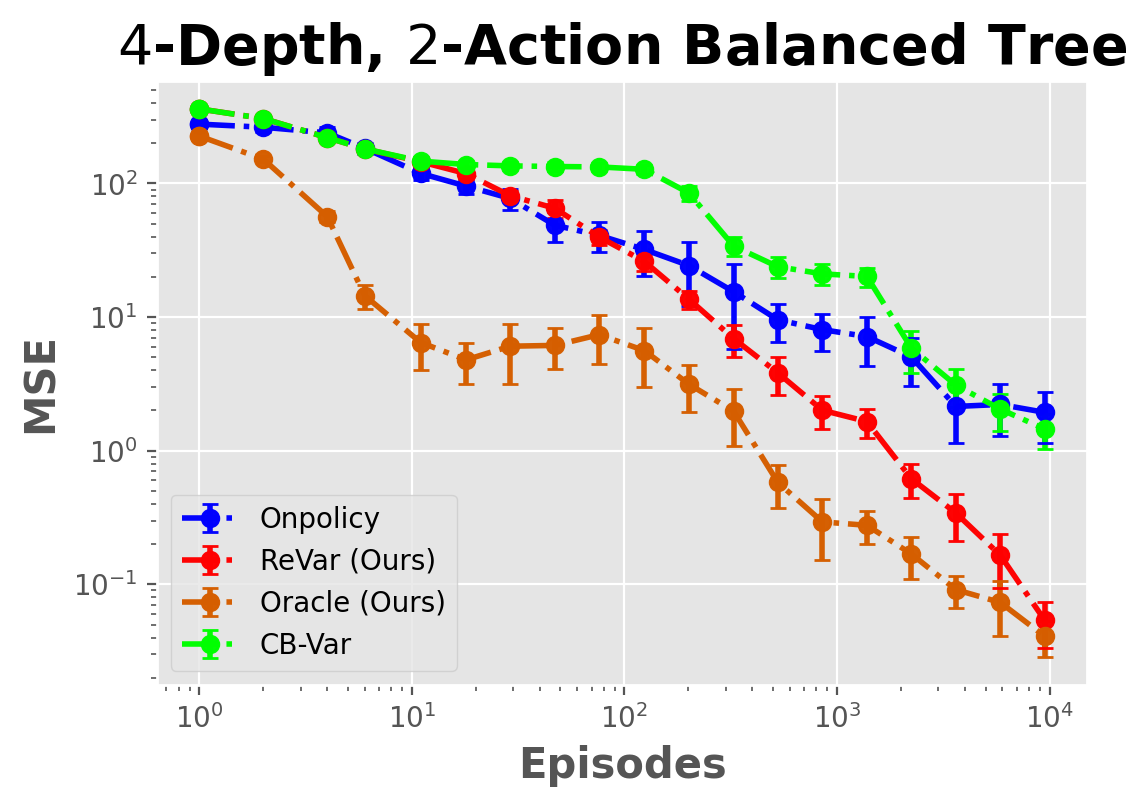

In [26]:
from numpy.core.fromnumeric import shape
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.figure(dpi=200)

env = Environment()
env.reset()
vi_true = value_iteration()
v_true = vi_true.run_value_iteration(env.R)[0]
# print(v_true)


error_onpolicy = (v_pi_onpolicy - v_true)**2
error_ucb_exploration_policy = (v_pi_ucb_exploration_policy - v_true)**2
error_oraclepolicy = (v_pi_oraclepolicy - v_true)**2
error_cbvarpolicy = (v_pi_cbvarpolicy - v_true)**2
error_mcucb_policy = (v_pi_mcucb_policy - v_true)**2

# print(np.shape(error_cbvarpolicy))
# print(error_cbvarpolicy)
# print(env.start_state)

error_onpolicy = error_onpolicy[:,:,0]
error_ucb_exploration_policy = error_ucb_exploration_policy[:,:,0]
error_oraclepolicy = error_oraclepolicy[:,:,0]
error_cbvarpolicy = error_cbvarpolicy[:,:,0]
error_mcucb_policy = error_mcucb_policy[:,:,0]

# error_cbvarpolicy = error_cbvarpolicy[:,:,0,0]


error_onpolicy = np.reshape(error_onpolicy, (env.num_trials, env.episodes))
error_ucb_exploration_policy = np.reshape(error_ucb_exploration_policy, (env.num_trials, env.episodes))
error_oraclepolicy = np.reshape(error_oraclepolicy, (env.num_trials, env.episodes))
error_cbvarpolicy = np.reshape(error_cbvarpolicy, (env.num_trials, env.episodes))
error_mcucb_policy = np.reshape(error_mcucb_policy, (env.num_trials, env.episodes))


# scale = np.arange(0, env.episodes, 10)
x = np.logspace(1, 1000, 20, base = 1.0092, endpoint = True)
scale = [int(i) for i in x]
print(scale)




k = 0.3


# # Plot with error bar
plt.errorbar(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], [k*np.std(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Onpolicy', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], [k*np.std(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='ReVar (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], [k*np.std(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Oracle (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], [k*np.std(error_cbvarpolicy, axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='CB-Var', linestyle = "-.", marker = "o", markersize = 6.0)
# plt.errorbar(scale, [np.average(error_mcucb_policy , axis=0)[i] for i in scale], [k*np.std(error_mcucb_policy, axis=0)[i] for i in scale], color = "#000000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='MCUCB', linestyle = "-.", marker = "o", markersize = 6.0)


# # Plot without error bar
# plt.plot(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, alpha = 4.0, label='Onpolicy', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, alpha = 4.0, label='Plugin-UCB (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, alpha = 4.0, label='Oracle (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, alpha = 4.0, label='CB-Var', linestyle = "-", markersize = 6.0)
plt.yscale('log')
plt.xscale('log')


plt.title('$4$-Depth, $2$-Action Balanced Tree', size = 20, fontweight='bold')



plt.xlabel("Episodes",fontweight='bold', fontsize = 15)
plt.ylabel("MSE",fontweight='bold', fontsize = 15)



plt.xlabel("Episodes")
plt.ylabel("MSE")

# plt.xlim(1,125)
# plt.ylim(0,1)
plt.legend()

# Load Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Write file

In [ ]:
import pickle

f1 = v_pi_onpolicy
f2 = v_pi_ucb_exploration_policy
f3 = v_pi_oraclepolicy
f4 = v_pi_cbvarpolicy
f5 = v_pi_mcucb_policy



with open('/content/drive/My Drive/Dataset/ReVar/tree_data_4_depth4.pickle', 'wb') as handle:
    pickle.dump([f1, f2, f3, f4, f5], handle, protocol=pickle.HIGHEST_PROTOCOL)


# Read Data

In [ ]:
import pickle

with open('/content/drive/My Drive/Dataset/ReVar/tree_data_4_depth4.pickle', 'rb') as handle:
    b = pickle.load(handle)

v_pi_onpolicy1 = b[0]
v_pi_ucb_exploration_policy1 = b[1]
v_pi_oraclepolicy1 = b[2]
v_pi_cbvarpolicy1 = b[3]
v_pi_mcucb_policy1 = b[4]



# Plot from Read File

[1, 1, 2, 4, 6, 11, 18, 29, 47, 76, 124, 201, 326, 527, 854, 1382, 2238, 3622, 5863, 9489]


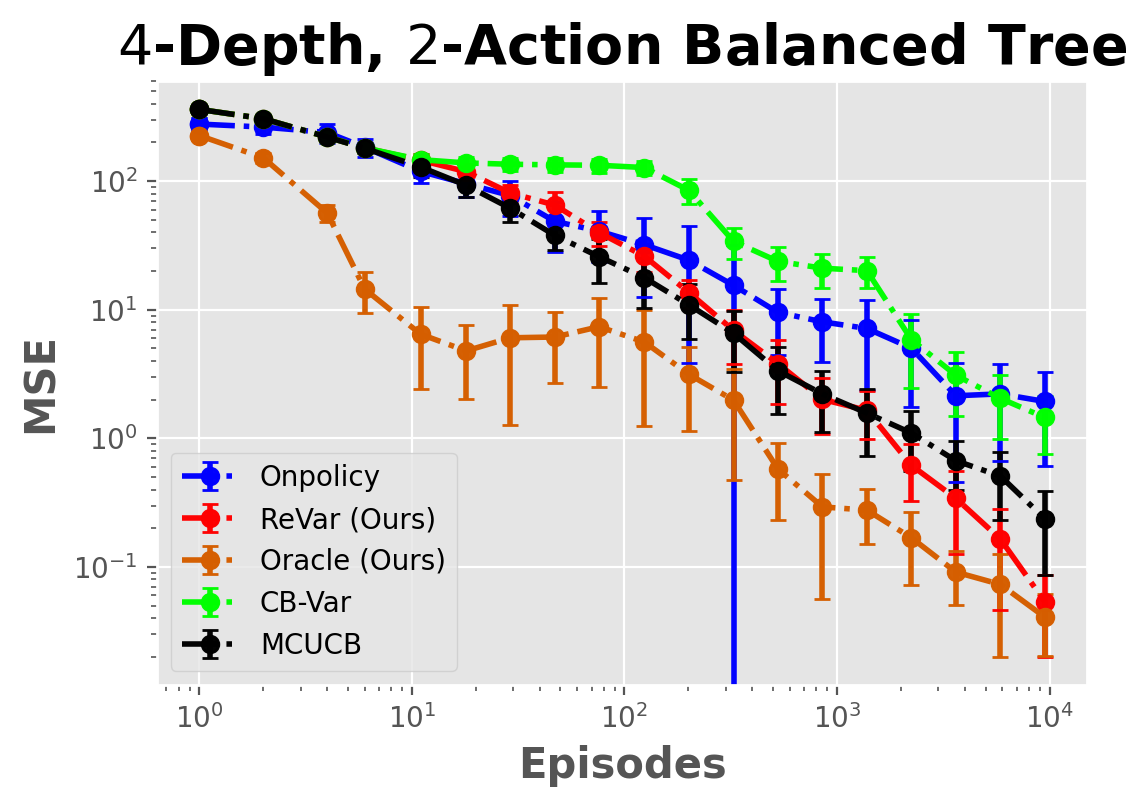

In [ ]:
from numpy.core.fromnumeric import shape
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
plt.figure(dpi=200)

env = Environment()
env.reset()
v_true = vi_true.run_value_iteration(env.R)[0]
# print(v_true)


error_onpolicy = (v_pi_onpolicy1 - v_true)**2
error_ucb_exploration_policy = (v_pi_ucb_exploration_policy1 - v_true)**2
error_oraclepolicy = (v_pi_oraclepolicy1 - v_true)**2
error_cbvarpolicy = (v_pi_cbvarpolicy1 - v_true)**2
error_mcucb_policy = (v_pi_mcucb_policy1 - v_true)**2

# print(np.shape(error_cbvarpolicy))
# print(error_cbvarpolicy)
# print(env.start_state)

error_onpolicy = error_onpolicy[:,:,0]
error_ucb_exploration_policy = error_ucb_exploration_policy[:,:,0]
error_oraclepolicy = error_oraclepolicy[:,:,0]
error_cbvarpolicy = error_cbvarpolicy[:,:,0]
error_mcucb_policy = error_mcucb_policy[:,:,0]

# error_cbvarpolicy = error_cbvarpolicy[:,:,0,0]


error_onpolicy = np.reshape(error_onpolicy, (env.num_trials, env.episodes))
error_ucb_exploration_policy = np.reshape(error_ucb_exploration_policy, (env.num_trials, env.episodes))
error_oraclepolicy = np.reshape(error_oraclepolicy, (env.num_trials, env.episodes))
error_cbvarpolicy = np.reshape(error_cbvarpolicy, (env.num_trials, env.episodes))
error_mcucb_policy = np.reshape(error_mcucb_policy, (env.num_trials, env.episodes))


# scale = np.arange(0, env.episodes, 10)
x = np.logspace(1, 1000, 20, base = 1.0092, endpoint = True)
scale = [int(i) for i in x]
print(scale)




k = 0.5


# # Plot with error bar
plt.errorbar(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], [k*np.std(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Onpolicy', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], [k*np.std(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='ReVar (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], [k*np.std(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='Oracle (Ours)', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], [k*np.std(error_cbvarpolicy, axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='CB-Var', linestyle = "-.", marker = "o", markersize = 6.0)
plt.errorbar(scale, [np.average(error_mcucb_policy , axis=0)[i] for i in scale], [k*np.std(error_mcucb_policy, axis=0)[i] for i in scale], color = "#000000", linewidth = 2, capsize = 3.0, capthick = 1.0, alpha = 4.0, label='MCUCB', linestyle = "-.", marker = "o", markersize = 6.0)


# # Plot without error bar
# plt.plot(scale, [np.average(error_onpolicy, axis=0)[i] for i in scale], color = "#0000FF", linewidth = 2, alpha = 4.0, label='Onpolicy', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_ucb_exploration_policy, axis=0)[i] for i in scale], color = "#FF0000", linewidth = 2, alpha = 4.0, label='Plugin-UCB (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_oraclepolicy, axis=0)[i] for i in scale], color = "#D55E00", linewidth = 2, alpha = 4.0, label='Oracle (Ours)', linestyle = "-", markersize = 6.0)
# plt.plot(scale, [np.average(error_cbvarpolicy , axis=0)[i] for i in scale], color = "#00FF00", linewidth = 2, alpha = 4.0, label='CB-Var', linestyle = "-", markersize = 6.0)
plt.yscale('log')
plt.xscale('log')


plt.title('$4$-Depth, $2$-Action Balanced Tree', size = 20, fontweight='bold')



plt.xlabel("Episodes",fontweight='bold', fontsize = 15)
plt.ylabel("MSE",fontweight='bold', fontsize = 15)



plt.xlabel("Episodes")
plt.ylabel("MSE")

# plt.xlim(1,125)
# plt.ylim(0,1)
plt.legend()